# Transformer

(RNN을 사용하지 않고, 인코더-디코더 구조를 설계하였음에도 번역 성능이 RNN보다 우수한 성능을 보여주었음)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## Transformer의 주요 hyperparameter

*아래 수치는 트랜스포머를 제안한 논문에서 사용한 수치로 사용자가 모델 설계시 임의로 변경할 수 있음*
- $d_{model} = 512 $: 임베딩 벡터의 차원  (각 인코더와 디코더가 다음 층의 인코더와 디코더로 값을 보낼 때에도 이 차원을 유지)
- $\text{num_layers} = 6$: 인코더와 디코더를 층으로 생각했을 때, 트랜스포머 모델에서 인코더와 디코더가 총 몇 층으로 구성되었는지를 의미
- $\text{num_heads} = 8$: 트랜스포머에서 어텐션을 사용할 때, 한번 하는 것보다 여러 개로 분할해서 병렬로 어텐션을 수행하고 결과값을 다시 하나로 합치는 방식을 택함. 이때 이 병렬의 개수를 **num_heads**로 표현
- $d_{ff} = 2048$: 트랜스포머 내부에는 피드포워드 신경망이 존재하는데, 해당 신경망의 **은닉층 크기**를 의미 --> 신경망의 입력층과 출력층 크기는 $d_{model}$임

## Positional Encoding

트랜스포머의 입력에 대해 먼저 알아보자.

RNN이 자연어 처리에서 유용했던 이유는 단어의 위치에 따라 단어를 순차적으로 입력받아서 처리하는 RNN의 특성으로 인해 각 단어의 위치 정보(position informaition)을 가질 수 있다는 점이었음.

하지만 트랜스포머는 단어 입력을 순차적으로 받는 방식을 채택하지 않음. 따라서 단어의 위치 정보를 다른 방식으로 알려줄 필요가 있음. 트랜스포머는 단어의 위치 정보를 얻기 위해서 각 단어의 임베딩 벡터에 위치 정보들을 더하여 모델의 입력으로 사용하는데, 이를 포지셔널 인코딩(positional encoding)이라고 함

In [2]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis], # tf.newaxis를 통해 차원을 하나 추가
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :], # tf.newaxis를 통해 차원을 하나 추가
            d_model=d_model
        )

        # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        angle_rads = np.zeros(angle_rads.shape)
        angle_rads[:, 0::2] = sines
        angle_rads[:, 1::2] = cosines
        pos_encoding = tf.constant(angle_rads)
        pos_encoding = pos_encoding[tf.newaxis, ...] # ...은 :와 비슷한 용도로 사용 가

        print(pos_encoding.shape)

        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

50 x 128 크기를 갖는 포지셔널 인코딩 행렬을 시각화 해보자.  --> (입력 문장의 단어 50개, 각 단어의 차원 128차원인 임베딩 벡터)

어떤 형태를 갖고 있을까?

Metal device set to: Apple M1 Pro
(1, 50, 128)


2022-12-24 13:45:15.896830: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-24 13:45:15.896974: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


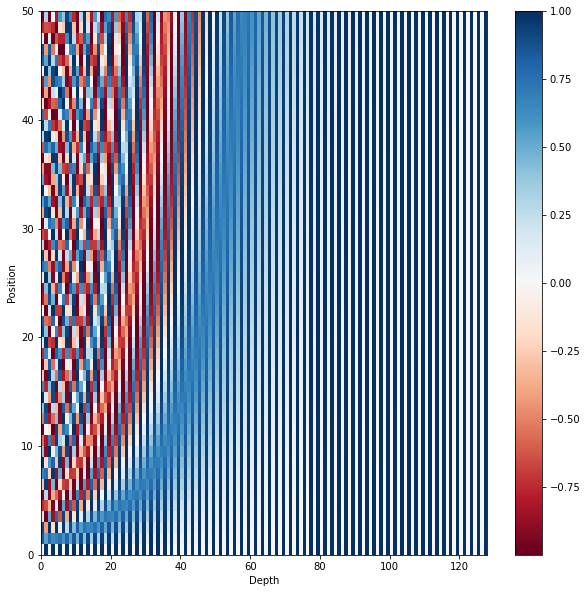

In [3]:
import matplotlib.pyplot as plt

# 문장의 길이 50, 임베딩 벡터 차원 128

sample_pos_encoding = PositionalEncoding(50, 128)  # 포지션은 총 50개. why? 단어가 50개임

plt.figure(figsize=(10, 10))
plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Attention

Transformer에서 사용되는 세 가지 어텐션에 대해 알아야 할 필요가 있음. 이 큰그림을 먼저 이해해야함

(Query, Key 등이 같다는 것은 벡터의 값이 같다는 것이 아니라 벡터의 출처가 같다는 의미)

- Encoder Self-Attention: Query = Key = Value (본질적으로 Query Key Value가 동일한 경우)
- Masked Decoder Self-Attention:  Query = Key = Value
- Encoder-Decoder Attention: Query(디코더 벡터) / Key = Value (인코더 벡터)

In [4]:
# scaled dot product attention 구현

def scaled_dot_product_attention(query, key, value, mask):
    """
    :param query: 쿼리 크기 (batch_size, num_heads, query 문장 길이, d_model / num_heads)
    :param key: 키 크기 (batch_size, num_heads, key 문장 길이, d_model / num_heads)
    :param value: 밸류 크기 (batch_size, num_heads, value 문장 길이, d_model / num_heads)
    :param mask: padding_mask 크기 (batch_size, 1, 1, key 문장 길이)
    :return:
    """

    # Attention Score Matrix : Q x KT
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # Scaling by sqrt(dk)
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # Masking -> Attention Score 행렬ㅇ서 마스킹 할 위치에 매우 작은 음수값 추가
    # 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0으로 변환
    if mask is not None:
        logits += (mask * -1e9)

    # softmax 마지막 차원인 key 문장 길이 방향으로 연산 수행
    # attention_weight : (batch_size, num_heads, query 문장 길이, key 문장 길이)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # output : (batch_size, num_heads, query 문장 길이, d_model/num_heads)
    output = tf.matmul(attention_weights, value)

    return output, attention_weights

In [5]:
# 함수 테스트
# temporary Q, K, V 행렬 생성 후 scaled_dot_product_attention 진행

np.set_printoptions(suppress=True)

temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1, 0],
                      [  10, 0],
                      [ 100, 5],
                      [1000, 6]], dtype=tf.float32)  # (4, 2)

temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)

쿼리에 해당하는 temp_q 값이 key 의 어느 부분과 일치하는지 체크 필요.

In [6]:
# 함수 실행하여 어텐션 분포 확인
temp_out, temp_attention = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_out)  # output -> 즉 어텐션 밸류
print(temp_attention)  # attention weights -> 어텐션 분포

tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)


- attention weights = (1, 4)
- values = (4, 2) 행렬
- 맷멀 결과 -> (1, 2) 행렬의 어텐션 벨류가 나옴
결과는 values (temp_v)의 두번째 행벡터 값과 같음


In [7]:
# 다른 테스트
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)

temp_out, temp_attention = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_out)
print(temp_attention)

tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)


temp_k 의 값을 살펴보고 매핑 시켜보자 -> `[0, 0, 10]` 이 두 개 있음.

또한 attention value는 [550, 5.5]는 Value의 세번째 값 [100, 5]에 0.5를 곱한 값과 네번째 값 [1000, 6]에 0.5를 곱한 값의 원소별 합임


In [8]:
# 3개 쿼리를 날려보면?

temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
temp_out, temp_attention = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_out) # 어텐션 값
print(temp_attention) # 어텐션 분포(어텐션 가중치의 나열)

tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)


## Multi-head Attention 구현

멀티 헤드 어텐션의 구현은 크게 다섯 가지 파트로 구성됩니다.

- WQ, WK, WV에 해당하는 d_model 크기의 밀집층(Dense layer)을 지나게한다.
- 지정된 헤드 수(num_heads)만큼 나눈다(split).
- 스케일드 닷 프로덕트 어텐션.
- 나눠졌던 헤드들을 연결(concatenatetion)한다.
- WO에 해당하는 밀집층을 지나게 한다.


In [9]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        # depth : d_model을 num_heads로 나눈 값
        # 논문 기준 64임
        self.depth = d_model // self.num_heads

        # WQ, WK, WV에 해당하는 밀집층 정의
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        # WO에 해당하는 밀집층 정의
        self.dense = tf.keras.layers.Dense(units=d_model)


    # num_heads 개수만큼 q, k, v를 쪼개는 함수
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth)  # recall num_heads x depth = d_model
        )
        return tf.transpose(inputs, perm=[0, 2, 1, 3])  # perm은 축 순서 정해줄 수 있음

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # 1: WQ, WK, WV에 해당하는 밀집층 지나기
        # q : (batch_size, query 문장 길이, d_model)
        # k : (batch_size, key 문장 길이, d_model)
        # v : (batch_size, value 문장 길이, d_model)
        # 인코더(k, v) - 디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를수 있음
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 2. 헤드 나누기
        # q: (batch_size, num_heads, query 문장 길이, d_model/num_heads)
        # k: (batch_size, num_heads, key 문장 길이, d_model/num_heads)
        # v: (batch_size, num_heads, value 문장 길이, d_model/num_heads)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 3. scaled dot product attention
        # (batch_size, num_heads, query 문장 길이, d_model/num_heads)
        # output만 출력, attention weights는 생략
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
        # (batch_size, query문장 길이, num_heads, d_model/num_heads)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 4. head 연결
        # (batch_size, query 문장 길이, d_model)
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 5. WO에 해당하는 밀집층 지나기
        # (batch_size, query 문장 길이, d_model)
        outputs = self.dense(concat_attention)

        return outputs

### 패딩 마스크(Padding Mask) 구현

In [10]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)  # x가 0과 같은지 bool을 리턴으로 받는 함수
    # (batch_size, 1, 1, key의 문장 길이)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [11]:
print(create_padding_mask(tf.constant([[1, 21, 777, 0, 0]])))

tf.Tensor([[[[0. 0. 0. 1. 1.]]]], shape=(1, 1, 1, 5), dtype=float32)


## 인코더 구현하기

- 인코더의 입력으로 들어가는 문장에 패딩이 있을 수 있으므로, 어텐션 시 패딩 토큰 제외 (패딩 마스크 사용)
- 총 두개의 서브층 (멀티헤드 어텐션 & 피드포워드 신경망)
- 각 서브층 이후 드롭아웃, 잔차연결, 층 정규화

In [12]:
def encoder_layer(dff, d_model, num_heads, dropout, name='encoder_layer'):
    """
    :param dff: FFNN hidden units
    :param d_model: embedding dim
    :param num_heads: parallels
    :param dropout: dropout rate
    :param name: layer name
    :return: model
    """
    inputs = tf.keras.Input(shape=(None, d_model), name='inputs')

    # Encoder는 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # Multi-head Attention (첫번째 서브층 / 셀프어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name='attention')({
        'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
        'mask': padding_mask  # 패딩 마스크 사용
    })

    # 드롭아웃 + residual connection + Layer Normalization
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # position-wise FFNN ( 두번째 서브층 )
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

## 인코더 쌓기

인코터 내부 아키텍쳐에 대해서 이해해보았음. 이러한 인코더 층을 num_layers개만큼 쌓고, 마지막 인코더 층에서 얻는 (seq_len, d_model) 크기의 행렬을 디코더로 보내주면서 트랜스포머 인코더의 인코딩 연산이 끝나게 됨

In [13]:
def encoder(vocab_size, num_layers, dff, d_model, num_heads, dropout, name='encoder'):
    inputs = tf.keras.Input(shape=(None, ), name='inputs')

    # 인코더는 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # positional encoding + dropout
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # 인코더를 num_layers개만큼 쌓기
    for i in range(num_layers):
        outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads, dropout=dropout,
                                name="encoder_layer_{}".format(i),)([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

## From Encoder to Decoder

### Look ahead mask 생성

In [14]:
# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 mask하는 함수
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    # band_part를 통해 삼각행렬 설정 가능 (tensor, -1, 0) 으로 활용 시 --> 하삼각행렬 생성
    # 마스킹을 하고자 하는 위치에 1, 하지 않는 위치에 0을 리턴
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x) # 룩어헤드를 한다고해서 패딩 마스크를 안하는 것은 아님. 이것도 만들어줘야함

    return tf.maximum(look_ahead_mask, padding_mask)

In [15]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))  # 패딩 테스트 용을 위해 정수 0을 넣었음.

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


룩어헤드 마스크이기에 삼각형 모양의 마스킹이 형성 -> 패딩 마스크가 포함되어 있는 세번째 열이 마스킹 됨

## 디코더 구현

총 3개의 서브층

- 첫번째 : 멀티헤드 어텐션 & look ahead mask  << masked self attention 수행을 하기 때문
- 두번째 : 멀티헤드 어텐션 & padding mask
- 세번째 : position-wise FFNN


In [16]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs") # encoder에서 온 아웃풋

    # look-ahead mask (첫번째 서브층)
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')

    # padding mask (두번째 서브층)
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # multi head attention (첫번째 서브층 / 마스크드 셀프 어텐션)
    attention1 = MultiHeadAttention(d_model, num_heads, name='attention_1')(inputs={
        'query': inputs, 'key': inputs, 'value': inputs,  # Q = K = V
        'mask': look_ahead_mask  # 룩어헤드 마스크
    })

    # residual connection and layer normalization
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    # multi-head attention (두번째 서브층 / 디코더-인코더 어텐션)
    attention2 = MultiHeadAttention(d_model, num_heads, name='attention_2')(inputs={
        'query': attention1, 'key': enc_outputs, 'value': enc_outputs,  # Q != K = V
        'mask': padding_mask
    })

    # dropout + res_connection + LN
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

    # position-wise FFNN (세번째 서브층)
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # dropout + res_connection + LN
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name
    )

## 디코더 쌓기

디코더도 마찬가지로 `num_layers`개 만큼 쌓아야함

In [17]:
def decoder(vocab_size, num_layers, dff, d_model, num_heads, dropout, name='decoder'):
    inputs = tf.keras.Input(shape=(None, ), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

    # 디코더는 룩어헤드와 패딩 마스크 둘 다 사용
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # PE + dropout
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)  # 단어 개수 x 임베딩 차원
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # 디코더를 num_layers개 쌓기
    for i in range(num_layers):
        outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
                                dropout=dropout, name='decoder_layer_{}'.format(i),
                                )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name
    )


## 트랜스포머 구현

인코더와 디코더 함수를 조합하여 트랜스포머 조립 진행

인코더의 출력은 디코더에서 [인코더-디코더]어텐션에 사용되기 위해 전달. 그리고 디코더 끝단에는 다중 클래스 분류 문제를 풀 수 있또록, vocab_size만큼의 뉴런을 갖는 출력층을 추가

In [18]:
def transformer(vocab_size, num_layers, dff, d_model, num_heads, dropout, name='transformer'):
    # 인코더 입력
    inputs = tf.keras.Input(shape=(None,), name='inputs')

    # 디코더 입력
    dec_inputs = tf.keras.Input(shape=(None, ), name="dec_inputs")

    # 인코더 패딩 마스크
    enc_padding_mask = tf.keras.layers.Lambda(create_padding_mask,
                                              output_shape=(1, 1, None),
                                              name='enc_padding_mask')(inputs)

    # 디코더의 look-ahead mask(first layer)
    look_ahead_mask = tf.keras.layers.Lambda(create_look_ahead_mask,
                                             output_shape=(1, None, None),
                                             name='look_ahead_mask')(dec_inputs)

    # 디코더의 패딩 마스크 (second layer)
    dec_padding_mask = tf.keras.layers.Lambda(create_padding_mask,
                                              output_shape=(1, 1, None),
                                              name='dec_padding_mask')(inputs)

    # 인코더의 출력 (enc_ouputs) -> decoder로 전달
    enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
                          d_model=d_model, num_heads=num_heads,
                          dropout=dropout,)(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩 마스크

    # 디코더의 출력 (dec_outputs) -> 출력층으로 전달
    dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
                          d_model=d_model, num_heads=num_heads,
                          dropout=dropout,)(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 다음 단어 예측을 위한 출력층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)


## Transformer Hyperparameters

현재 훈련 데이터는 없지만, 단어 집합의 크기는 임의로 9000으로 정함.

단어 집합의 크기로부터 룩업 테이블을 수행할 임베딩 테이블과 포지셔널 인코딩 행렬의 행의 크기를 결정할 수 있음.

(1, 9000, 128)
(1, 9000, 128)


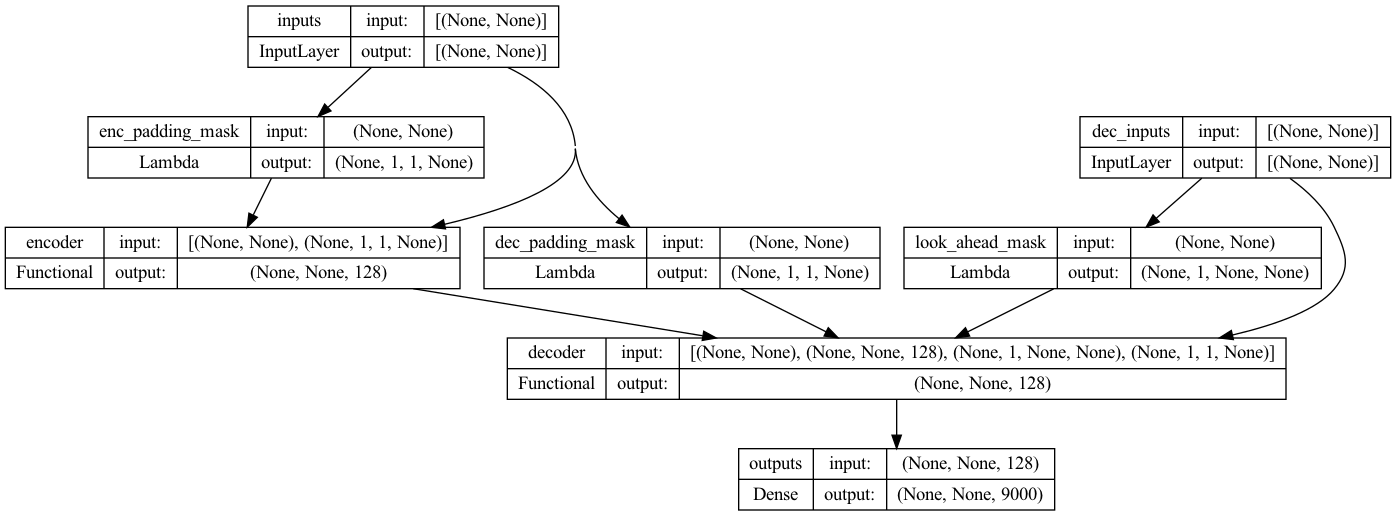

In [19]:
small_transformer = transformer(
    vocab_size=9000,
    num_layers=4,
    dff=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="small_transformer"
)

tf.keras.utils.plot_model(small_transformer, to_file='small_transformer.png', show_shapes=True)

## 손실 함수 정의

In [20]:
# 다중 클래스 분류 문제를 위한 크로스 엔트로피
# def loss_function(y_true, y_pred):
#     y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
#
#     loss = tf.keras.losses.SparseCategoricalCrossentropy(
#         from_logits=True, reduction='none')(y_true, y_pred)
#
#     mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
#     loss = tf.multiply(loss, mask)
#
#     return tf.reduce_mean(loss)

## 학습률 스케쥴러 (Learing rate Scheduler)

학습률 스케줄러(Learning rate Scheduler)는 미리 학습 일정을 정해두고 그 일정에 따라 학습률이 조정되는 방법입니다. 트랜스포머의 경우 사용자가 정한 단계까지는 학습률을 증가시켰다가 단계에 이르면 학습률을 점차적으로 떨어트리는 방식을 사용합니다. 좀 더 구체적으로 봅시다. step_num(단계)이란 옵티마이저가 매개변수를 업데이트 하는 한 번의 진행 횟수를 의미합니다. 트랜스포머에서는 warmup_steps이라는 변수를 정하고 step_num이 warmup_steps보다 작을 경우는 학습률을 선형적으로 증가 시키고, step_num이 warmup_steps에 도달하게 되면 학습률을 step_num의 역제곱근에 따라서 감소시킵니다. 이를 식으로 표현하면 아래와 같습니다. warmup_steps의 값으로는 4,000을 사용하였습니다.

In [21]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

학습률 변화 시각화

Text(0.5, 0, 'Train Step')

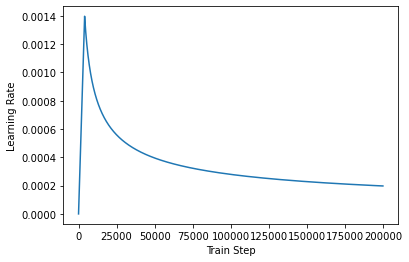

In [22]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')